# VolDen Tutorial
This tutorial leads the user through all of the steps required to generate the volume density map of elongated filament from its column density map. `VolDen` should be used in Python 3.5, Python 3.6, or Python 3.9 (Python 3.9 is recommended). **Please avoid using Python 3.8.16 or Python 3.8 in general because there were some bugs encountered with this version.**

For our paper, we used the following versions:

`Python Version: 3.9.18`

`Dependencies`:
- Matplotlib (3.6.3)
- Numpy (1.24.4)
- Astropy (5.0.1)
- Scipy (1.8.0)
- Pandas (1.4.0)
- shapely (1.8.1)
- networkx (2.7)
- scikit-learn (1.1.0)
- scikit-image (0.19.2)
- seaborn (0.13.1)
- descartes (1.1.0)

Our filament of choice for this tutorial is the Taurus B213 segment and its surrounding regions, which are part of the 10-pc-long large-scale filament LDN 1495 in the Taurus molecular cloud. We will use RadFil on the clipped region of column density data for the Taurus region produced by [Palmeirim et al (2013)](https://www.aanda.org/articles/aa/abs/2013/02/aa20500-12/aa20500-12.html). The data for this tutorial are kept locally in the *tutorial_dat* folder. The user can access the full data from the Herschel Gould Belt Survey archives [here](http://www.herschel.fr/cea/gouldbelt/en/Phocea/Vie_des_labos/Ast/ast_visu.php?id_ast=66). 

Before proceeding further, ***please ensure that you have the fits image for the source of interest and its corresponding fits file for the filament's spine***. If you don't have the spine for your filament, you can produce one by using the [FilFinder package](https://github.com/e-koch/FilFinder). **NOTE**: The current version of `VolDen` will not work for complex filamentary structure having branched like spine. 

Okay now we are ready to extract volume density map. 

# **Let's get started!** 

**Step 1:** We are going to extract the radial profiles of the column density data using `RadFil`. There are multiple parameters available in `RadFil`, but here we will be focussing on the most valuable ones. We will be calling the function `volden_radfil()` and it has the following parameters:

- **image** -- 2D fits column density data of the filament
- **header** -- header of the corresponding image
- **spine** -- 2D boolean array corresponding to the central spine of the filament. It can be produced using [FilFinder](https://github.com/e-koch/FilFinder).
- **sample_int** --  This parameter has been taken from [`RadFil`](https://github.com/catherinezucker/radfil/blob/master/RadFil_Tutorial.ipynb). Its a integer corresponding to the sampling frequency (in pixels). It controls how finely you want to make cuts across the spine. When entered as an integer, this shows the approximate distance in pixels between cuts (samp int=25 indicates that the cuts are 25 pixels apart, or 25 x imgscale in pc).
- **distance** -- the distance to the filament (in pc)
- **cutdist** -- This parameter has been taken from [`RadFil`](https://github.com/catherinezucker/radfil/blob/master/RadFil_Tutorial.ipynb). The radial distance from the spine you'd like to search for the peak column density along each cut (in pc). `RadFil` generates a mask for you by locating all points within a "cutdist" distance of the spine. 
- **avg** (optional) -- If True, then mean radial profiles of North and South region of the filament will also get return. default: True

Before proceeding to **Step 1** we will first extract all the necessary packages we need. We will discuss about each of the remaining `VolDen` utilities later in the tutorial.

In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u
from astropy.nddata.utils import Cutout2D
import numpy as np
from astropy.wcs import WCS

import warnings
warnings.filterwarnings('ignore')

#Importing volden package

from volden.volden_main import volden_radfil, volden_plummer_fit, cloud_boundary, total_data

Now we are going to read in our fits image and fits spine (created by using [FilFinder](https://github.com/e-koch/FilFinder)) via astropy.

Text(0.5, 1.0, 'Filament Spine')

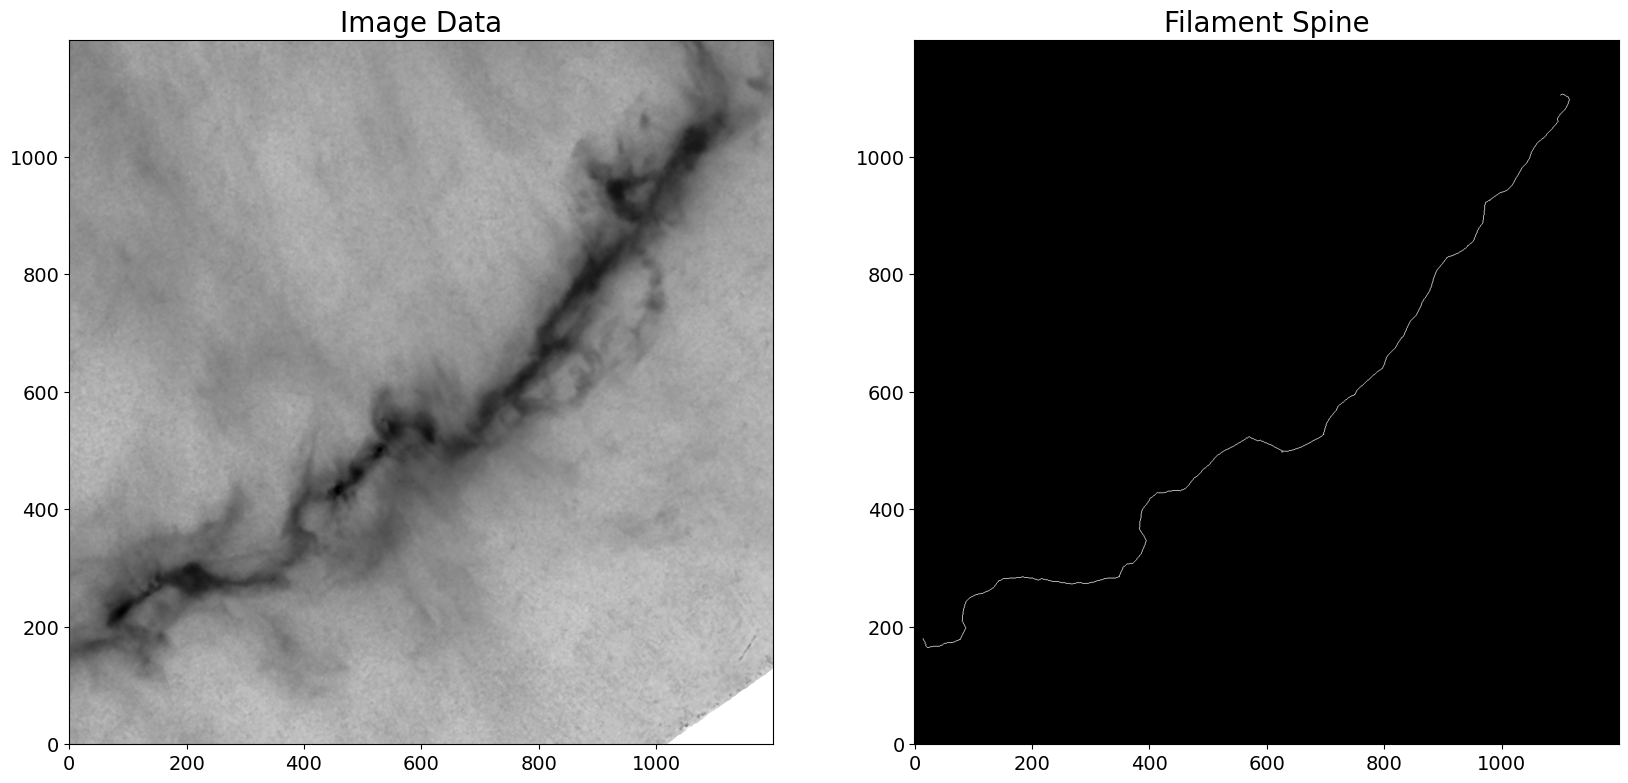

In [2]:
f = 'taurus_b213_colden_image.fits'

fil_image,fil_header=fits.getdata(f, header=True)
wcs = WCS(fil_header)

f = 'taurus_b213_spine.fits'
fil_image=fil_image
fil_spine=fits.getdata(f).astype(bool)

#plot our image and mask
fig, ax = plt.subplots(figsize=(20,10), ncols = 2)

ax[0].imshow(fil_image,origin='lower',cmap='Greys',norm=LogNorm())
ax[0].set_title("Image Data")

ax[1].imshow(fil_spine, origin="lower",cmap='Greys_r')
ax[1].set_title("Filament Spine")

Now let's call `volden_radfil()` to build the radial profiles. Here we are going to use a distance of 140 pc to the Taurus star forming region ([Elias 1978](https://www.aanda.org/articles/aa/full_html/2019/03/aa34399-18/aa34399-18.html#R17)), *`sample_int`* = 6 pixels in order to match with the beamwidth of the column density map (18.2") and will set a *`cut_dist`* = 0.02 pc. The process can take time depending on the *`sample_int`* and image size. Below represents the return from the function `volden_radfil()`. 

    Returns:

    radial distance and the respective profiles of North and South regions across
    the filament.

    north_radius : numpy.ndarray
        radial distance array of north region
    north_profile : numpy.ndarray
        profile array of north region
    south_radius : numpy.ndarray
        radial distance array of south region
    south_profile : numpy.ndarray
        profile array of south region

    "Below parameters gets return only when avg = True"

    north_radius_ : numpy.ndarray
        mean radial distance array of north region
    north_profile : numpy.ndarray
        mean profile array of north region
    south_radius : numpy.ndarray
        mean radial distance array of south region
    south_profile: numpy.ndarray
        mean profile array of south region

**Note**: You can notice a line in the plot showing the radial cuts. That's just an one such cut for which the ordering was not properly calculated via the `RadFil` workflow. It'll have negligible effects on our analysis. The drop of certain column density profiles beyond 1 pc is due to the NaN values present in the orginal column density values.  *Red and Blue color plots corresponds to the profiles extracted in the North and South Part of the filament respectively.*

No binning is applied.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


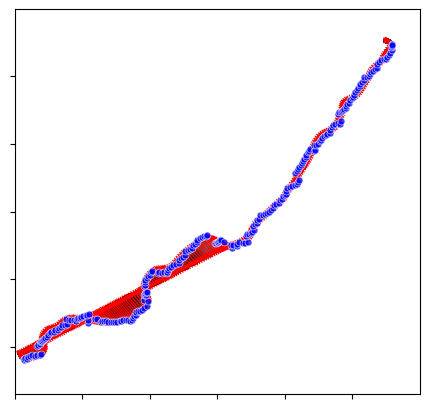

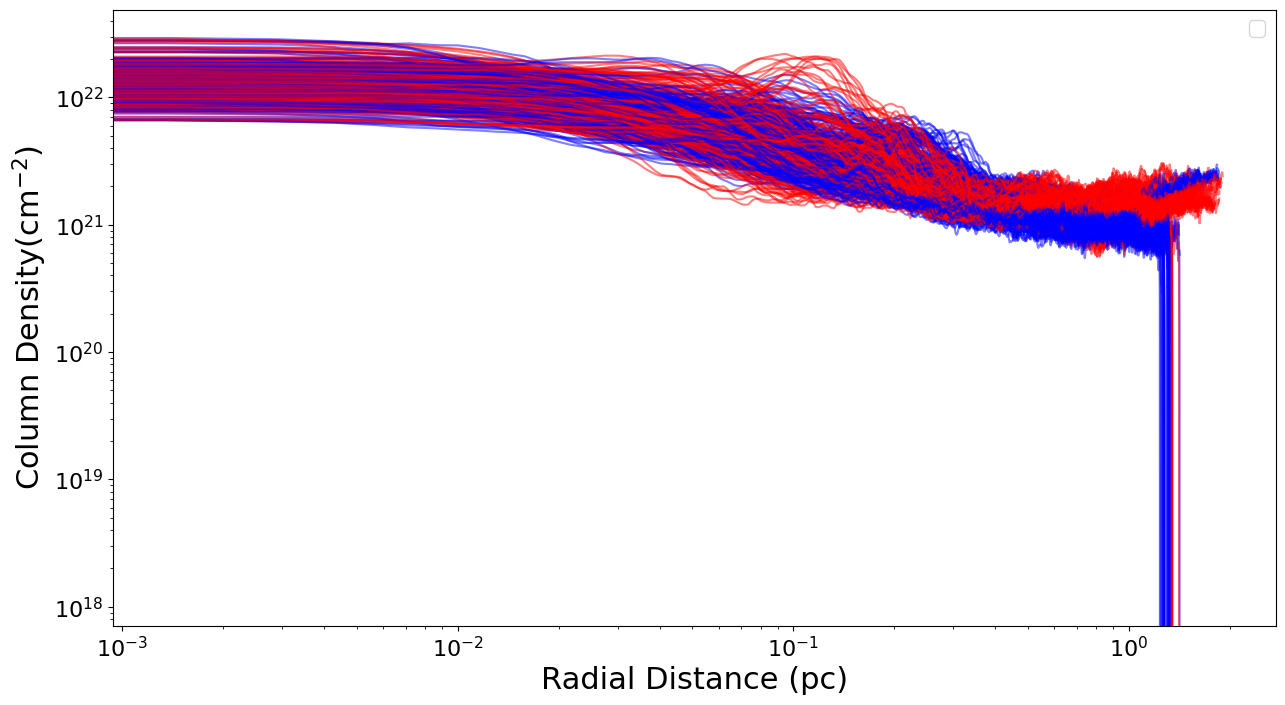

In [3]:
north_radius, north_profile, south_radius, south_profile, avg_north_radius, avg_north_profile, avg_south_radius, avg_south_profile = volden_radfil(
    image = fil_image, header = fil_header, spine= fil_spine, sample_int = 6, 
    distance = 140, cutdist = 0.02, avg = True) 

plt.figure(figsize=(15,8))    

for i in range(0,len(north_radius)):
    plt.plot(south_radius[i], south_profile[i],c='blue',alpha=0.5) # "South"
    plt.plot(north_radius[i], north_profile[i],c='red',alpha=0.5) # "North"

plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e+21,9e+22)
plt.legend(fontsize=15)
plt.xlabel("Radial Distance (pc)",fontsize=22)
plt.ylabel(r"Column Density(cm$^{-2}$)",fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)

Now we will plot the average column density profiles for the North and South regions that we got by using *`volden_radfil()`*

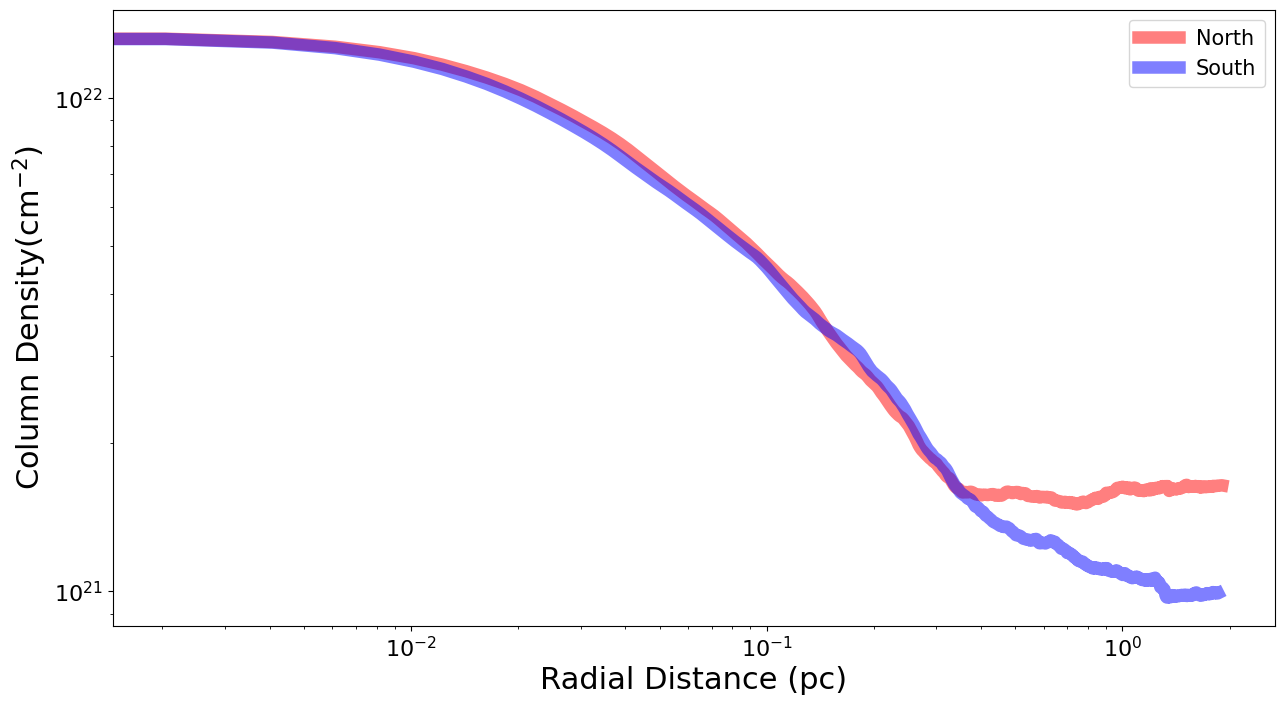

In [4]:
plt.figure(figsize=(15,8))
plt.plot(avg_north_radius, avg_north_profile, linewidth=9, c='red',alpha=.5, label = 'North')
plt.plot(avg_south_radius, avg_south_profile, linewidth=9, c='blue',alpha=.5, label = 'South')

plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=15)
plt.xlabel("Radial Distance (pc)",fontsize=22)
plt.ylabel(r"Column Density(cm$^{-2}$)",fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)

## **Step 1 done!**

**Step 2**: We are assuming that the filament follow a cylinderical geometry about the filament’s spine.  Since the density structures of the filaments identified based on Herschel data can be well explained by a Plummer-like profile, we have used the Plummer-like model to fit the extracted column density
profiles (as shown by [Arzoumanian et al. (2011)](https://www.aanda.org/articles/aa/abs/2011/05/aa16596-11/aa16596-11.html)). Here are the model equations:

 $$\rm n_{p}(r) = \frac{n_{c}}{[1 + (\frac{r}{R_{flat}})^{2}]^{\frac{p}{2}}}$$


 $$\rm N_{p}(r) = \frac{N_{0}}{[1 + (\frac{r}{R_{flat}})^{2}]^{\frac{p-1}{2}}} \, ;N_{0} = A_{p}n_{c}R_{flat}$$

 $$\rm A_{p} = \cos{i} \int_{-\infty}^{\infty}{ (1+s^{2})^{\frac{p}{2}}ds}$$
;where $\rm N_0$ is the column density profile amplitude, $n_{p}(r)$ and $N_{p}(r)$ are the respective $H_{2}$  volume density and column density values at a radial offset of distance $r$ to the filament ridge. The model parameter $n_{c}$ represents the volume density at the filament ridge, $R_{flat}$ is the scaling radius at which $N_{p}(r)$ remains constant and $p$ is the profile index that determines the slope of the profiles falling beyond $R_{flat}$. $A_{p}$ is a constant that takes account of the inclination angle made by the filament with the plane of the sky.

For doing the Plummer model fitting we are going to use `volden_plummer_fit()`. The below shows the required arguments and the corresponding returns from the function:

    Arguments:

    radial : numpy.ndarray
        radial distance of each cuts array 
    profile : numpy.ndarray
        extracted profiles of each cuts array
    bounds : nlist
        bounds on the plummer model parameters (nc, p and Rflat). If
        bounds = None, then then default values will be considered for 
        model fit
    init : list
      initialised values of the model parameters (nc, p and Rflat). If 
      init = None, then default values will be considered for model 
      fit. User can also enter their
      choice of initial values
    error : bool, optional
        If true then the error in the model parameters will also get returned

    Returns:

    nc : numpy.ndarray
      volume density profile at radial offset r to the the filament ridge array
    p : numpy.ndarray
      profile index array
    rflat : list
      the radius within which the N(r) profile is flat

    If error = True, then the fitting errors for the model parameters i.e. nc_err, p_err and rflat_err will also gets returned


**We also need to define some `initialParameters` and `bounds` for the model parameters. The user needs to define the corresponding values in the following format:**

 - `initialParameters` = [$N_{0}$, $p$, $R_{flat}$]

 - `bounds` = [[$N_{0}^{i}$, $p^{i}$, $R_{flat}^{i}$][$N_{0}^{f}$, $p^{f}$, $R_{flat}^{f}$]]; where superscript i and f represents the two extreme bound points.

One can define the above two by inspecting the average density profile plots that we produced earlier. Here we are using following values:
 - `initialParameters` = [5.0e+21, 1.5, 0.02]

 - `bounds` = [[1.0e+21,1.0,0.01],[1.0e+23,2.3,0.1]]

In [5]:
initialParameters = np.array([5.0e+21, 1.5, 0.02]) 
bound = [[9.0e+20,1.0,0.01],[1.0e+23,2.3,0.1]]

# FoR North
nc_N, p_N, rflat_N, nc_err_N, p_err_N, rflat_err_N = volden_plummer_fit(north_radius, north_profile, 
                                                            bounds = bound, init = initialParameters, 
                                                            error = True)

# For South
nc_S, p_S, rflat_S, nc_err_S, p_err_S, rflat_err_S = volden_plummer_fit(south_radius, south_profile, 
                                                            bounds = bound, init = initialParameters, 
                                                            error = True)

print('For North\n', np.mean(nc_N),np.mean(p_N),np.mean(rflat_N),'\n±')
print(np.std(nc_N),np.std(p_N),np.std(rflat_N), '\n')

print('For South\n', np.mean(nc_S),np.mean(p_S),np.mean(rflat_S),'\n±')
print(np.std(nc_S),np.std(p_S),np.std(rflat_S))

For North
 78763.80335387493 1.7624975373118232 0.033156802248603796 
±
56834.32267883687 0.269436281065964 0.03077549011632188 

For South
 69849.8234254132 1.8487627735887622 0.035833319926563745 
±
59050.71509790553 0.24498409920535022 0.027642498690437355


In [6]:
print(np.min(nc_N))
print(np.max(nc_N),'\n')

print(np.min(p_N))
print(np.max(p_N),'\n')

print(np.min(rflat_N))
print(np.max(rflat_N),'\n')
print('=========')
print(np.min(nc_S))
print(np.max(nc_S),'\n')

print(np.min(p_S))
print(np.max(p_S),'\n')

print(np.min(rflat_S))
print(np.max(rflat_S),'\n')
#, nc_S, p_N, p_S, rflat_N, rflat_S)
#np.max(nc_N, nc_S, p_N, p_S, rflat_N, rflat_S)

6014.181806043659
254764.7147363342 

1.3185879737179336
2.2999999999999994 

0.010000000000000002
0.09999999999999999 

5638.748406184369
297503.58397870953 

1.3936499735195094
2.2999999999999994 

0.010000000000000002
0.09999999999999999 



248

# **Step 2 done!**

**Step 3:** The Plummer-like profile of the cloud extends to infinity, thus describing a structure having no fixed boundary. Thus we need to employ a Cloud Boundary condition on the extracted profiles. Here we are going to assume that the column density around the central portion of the filament contributes half of the total column density values and use the Cloud Boundary Condition described by [Wang et al.(2019)](https://doi.org/10.3847/1538-4357/ab5c1c) to extract the thickness ($D$) map:

$$ \frac{\int_{\frac{-D}{2}}^{\frac{D}{2}}{n_{p}(r)dr_{los}}}{\int_{-\infty}^{\infty}{n_{p}(r)dr_{los}}} = \frac{1}{2}$$


We are going to use the `cloud_boundary()` function to employ the Cloud Boundary condition. The below shows the required arguments and the corresponding returns from the function:

    Arguments:

    radial : numpy.ndarray
        radial distance of each cuts array 
    profile : numpy.ndarray
        extracted profiles of each cuts array
    nc : numpy.ndarray
        volume density profile at radial offset r to the the filament ridge
    p : numpy.ndarray
        The power-law index
    rflat : numpy.ndarray
        R_flat in the function
    init_D : float, optional
        initialised value of thickness. If not defined by user then the default
        value will be considered. default = 0.01
    threshold : float, optional
      The threshold for error in the cloud boundary ratio equation as defined by
      Wang et al. 2020 in equation 4.If not defined by user then the default
      value will be considered. default = 1e-8
    ratio: float, optional
      default = 0.5. The ratio in the cloud boundary condition we are using in this analysis.

    Returns:

    rpos : numpy.ndarray
        radial distance(plane of the sky) from the filament ridge
    D : numpy.ndarray
        thickness values of each profiles

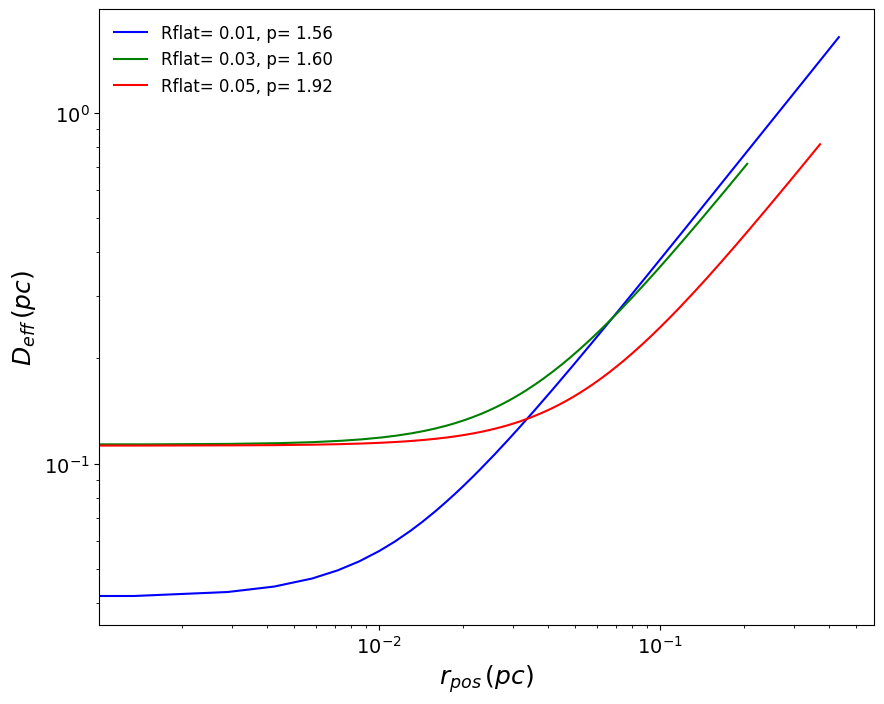

In [7]:
# The cloud boundary condition for North
rpos_north, D_north = cloud_boundary(north_radius, north_profile, nc = nc_N, 
                         rflat = rflat_N, p = p_N, init_D = 0.02)

# The cloud boundary condition for South
rpos_south, D_south = cloud_boundary(south_radius, south_profile, nc = nc_S, 
                         rflat = rflat_S, p = p_S, init_D = 0.02)


#plotting D_vs_rpos
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
c = ['b','g','r']
h = 0
for z in 1,10,27:
    ax.plot(rpos_north[z],D_north[z],c = c[h] ,label ='Rflat= {0:.2f}, p= {1:.2f}'.format(rflat_N[z],p_N[z]))
    ax.legend(loc='upper left', frameon=False)
    h += 1

plt.xlabel("$r_{pos}\,(pc)$",fontsize=18)
plt.ylabel(r"$D_{eff}\,(pc)$",fontsize=18)
plt.xscale('log')
plt.yscale('log')

plt.show()

# **Step 3 done!**

**Step 4**: Now we have everything to build the thickness and subsequently the volume density map. First we are going to build a catalogue of each coordinates and its corresponding column density and thickness values by using the `total_dat()` function. The below represents the essential arguments and return of the function `total_dat()`:

      Arguments:
      profile_north : numpy.ndarray
          extracted profiles in plane of the sky for each cuts in the North direction
      profile_south : numpy.ndarray
          extracted profiles in plane of the sky for each cuts in the South direction
      rpos_north : numpy.ndarray
          radial distance in plane of the sky for each cuts in the North direction
      rpos_south : numpy.ndarray
          radial distance in plane of the sky for each cuts in the South direction
      D_north : numpy.ndarray
          thickness values in plane of the sky for each cuts in the North direction
      D_south : numpy.ndarray
          thickness values in plane of the sky for each cuts in the South direction
          
      Returns:

    Computing the total data for the thickness map

In [8]:
# Troubleshooting/debugging the error
tot_dat = total_data(north_profile,south_profile,rpos_north, rpos_south, D_north,D_south)

In [9]:
# saving the total catalogue for future uses
tot_dat.to_csv('taurus_total_data.csv', index = False)

# **Step 4 done!**

**Step 4**: Now we have everything to build the thickness and subsequently the volume density map. First we are going to build the thickness map by using the `compute_thickness_map()` function. The below represents the essential arguments and return of the function `compute_thickness_mao()`:

    Arguments:
    data: string
          the directory where the total 2D dataframe of the thickness values are saved
    fil_image: numpy.ndarray
          the filament image 2D numpy array
    fil_header: the header of the filament image fits file
    sample_int: integer
        The integer corresponding to the sampling frequency that the user used initially
        while extracting the radial profiles using radfil (in pixels)
        
    Returns:
    thickness map 2D numpy array

**Note:** The process can take time depending on the input image size. 


In [10]:
from volden.final_maps import compute_thickness_map
thickness_map = compute_thickness_map("taurus_total_data.csv", fil_image, fil_header, sample_int = 6)

Text(0, 0.5, 'Dec (J2000)')

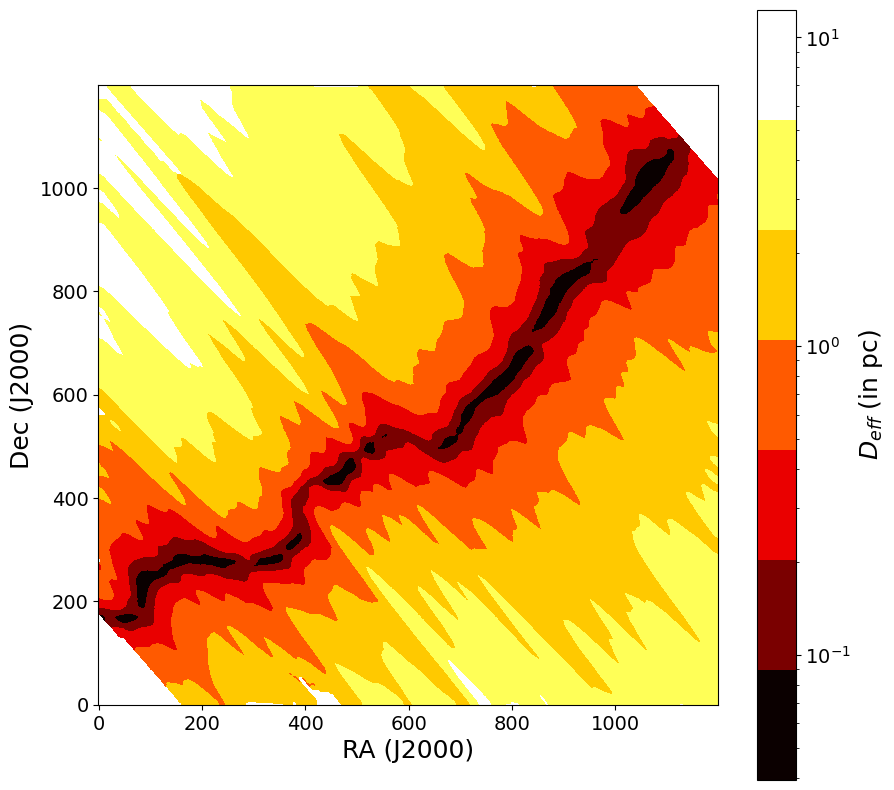

In [14]:
#thickness_map[np.where(fil_image == np.nan)] == 0
plt.figure(figsize=(10,10))
#plt.subplot(projection=wcs)
cm = plt.cm.get_cmap('hot', 7)
a = plt.imshow(thickness_map, origin='lower', cmap=cm, norm=LogNorm())
cbar = plt.colorbar(a)
cbar.set_label('$D_{eff}$ (in pc)')
plt.xlabel("RA (J2000)")
plt.ylabel("Dec (J2000)")

# **Optional Step**
Depending on the output maps, if you want to make a smooth version of your thickness map (because of missing pixel values or noise), then this step will be useful for you. We are going to use astropy’s `Gaussian2DKernel` as a filter and Fast
Fourier Transform(FFT) as a convolution technique. So let's begin! 

**Note**: *We are using FFT method here because our kernel size is of the order 8 $\sigma$. If your kernel size is small, you can use astropy's `convolve()` function instead of `convolve_fft()`. Here we cropped the image edges, where the thickness values gets interpolated to low values near the image edges as a consequence of the FFT. In most cases you don't need to smoothen the map if your map size is small, but if its very large it might inhomogeneities (as we have here) then you may need to use this step.*

In [ ]:
from astropy.convolution import Gaussian2DKernel, convolve_fft, convolve
from astropy import units as u
from astropy.nddata.utils import Cutout2D

# Smoothing using gaussian2Dkernel
kernel = Gaussian2DKernel(x_stddev=8*2.5760509554140127, y_stddev=8*2.5760509554140127)
smooth_thickness_map = convolve_fft(thickness_map, kernel)

#removing the outlier values for thickness that may be generated using FFT method. We are cropping the thickness map to remove the outliers
#below parameters were obtained from ds9

position = (589.05607, 593.53504) #pixel
size = u.Quantity((1091.5748,1091.5748), u.pixel)  #pixel

cutout = Cutout2D(smooth_thickness_map, position, size, wcs = wcs)
smooth_thickness_map = cutout.data
smooth_wcs = cutout.wcs

plt.figure(figsize=(10,10))
plt.subplot(projection=smooth_wcs)
cm = plt.cm.get_cmap('hot',7)
a = plt.imshow(smooth_thickness_map, origin='lower',cmap=cm, interpolation='nearest', norm=LogNorm())
cbar = plt.colorbar(a)
cbar.set_label('$D_{eff}$ (in pc)')
plt.xlabel("RA (J2000)")
plt.ylabel("Dec (J2000)")

# **Final Step**

Now we have the column density and thickness map. We will be using `number_density_map()` function which uses the below relation to derive the number density map:

$$ {n(H_{2})} = \frac{N_{H_{2}}}{2D}$$

We only need to feed the produced thickness map to the `number_density_map()` function in order to get the volume density map.

**Note:** *Since we have cropped the thickness map, so we are also cropping the original column density map to calculate the number density map.*

In [ ]:
from volden.final_maps import number_density_map

#similarly cropping the column density map accordingly
fil__image = Cutout2D(fil_image, position, size).data

#number_density_map
taurus_number_density = number_density_map(fil__image, smooth_thickness_map)
#taurus_number_density[np.where(taurus_number_density) == np.nan] = 0
#taurus_number_density[np.where(taurus_number_density < 10)] = 0

plt.figure(figsize=(10,10))
plt.subplot(projection=smooth_wcs)
cm = plt.cm.get_cmap('RdYlBu')
a = plt.imshow(taurus_number_density, origin='lower', cmap=cm, norm=LogNorm())
cbar = plt.colorbar(a)
cbar.set_label('$n(H_{2})$ (in $cm^{-3}$)')
plt.xlabel("RA (J2000)")
plt.ylabel("Dec (J2000)")

**Finally, saving the maps in the produced_maps directory as a .txt format**

In [ ]:
np.savetxt("produced_maps/final_coldensity_taurusb213.txt", fil__image)
np.savetxt("produced_maps/final_thickness_taurusb213.txt", smooth_thickness_map)
np.savetxt("produced_maps/final_voldensity_taurusb213.txt", taurus_number_density)

**Creating a new header for the column density, thickness and volume density map. And finally saving it as a fits file**



In [ ]:
# Saving the maps
image,head=fits.getdata("taurus_b213_colden_image.fits", header=True)
wcs_crop = WCS(head)

#cropping to remove the outliers

#below parameters were obtained from ds9
position = (589.05607, 593.53504) #pixel
size = u.Quantity((1091.5748,1091.5748), u.pixel)  #pixel (1170.5057,1161.5748) ,,,(1100.5057,1091.5748)

#image data
cutout = Cutout2D(image, position, size, wcs = wcs_crop)
cropped_wcs = cutout.wcs
image = cutout.data
head.update(cutout.wcs.to_header())


head['CRPIX1'] = 589.05607
head['CRPIX2'] = 593.53504
cr_ra = round(float(wcs.pixel_to_world_values(head['CRPIX1'],head['CRPIX2'])[0]), 5)
cr_dec = round(float(wcs.pixel_to_world_values(head['CRPIX1'],head['CRPIX2'])[1]), 5)
head['CRVAL1'] = cr_ra
head['CRVAL2'] = cr_dec

header0 = head
fits.writeto('produced_maps/final_taurus_coldensity.fits',image,header0, overwrite= True)

header1 = head
header1['BUNIT'] = 'H2.cm^-3'
fits.writeto('produced_maps/final_taurus_number_density_map.fits',taurus_number_density, header1, overwrite= True)

header2 = head
header2['BUNIT'] = 'pc'
fits.writeto('produced_maps/final_taurus_thickness_map.fits',smooth_thickness_map, header2, overwrite= True)